In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../input/ump-dataset/train.parquet", columns=features)
display(features)

target = pd.read_parquet("../input/ump-dataset/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet("../input/ump-dataset/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [5]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [6]:
import gc
gc.collect()

111

***
## model training: finding number of iterations

In [7]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [8]:
model_params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 55,
    'learning_rate': 0.05,
    'feature_fraction': 0.616,
    'bagging_fraction': 0.8,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'lambda_l1': 3.563444727371679,
    'lambda_l2': 0.30026771722107604,
    'bagging_freq': 0,
    'min_child_samples': 100,
    'extra_trees': True,
    'extra_seed': 19,
    'seed': 19,
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 0.89962	valid_0's pearsonr: 0.1114
[40]	valid_0's rmse: 0.89813	valid_0's pearsonr: 0.117925
[60]	valid_0's rmse: 0.897356	valid_0's pearsonr: 0.121444
[80]	valid_0's rmse: 0.89691	valid_0's pearsonr: 0.123411
[100]	valid_0's rmse: 0.896634	valid_0's pearsonr: 0.124667
[120]	valid_0's rmse: 0.896425	valid_0's pearsonr: 0.125545
[140]	valid_0's rmse: 0.896239	valid_0's pearsonr: 0.126534
[160]	valid_0's rmse: 0.896163	valid_0's pearsonr: 0.126629
[180]	valid_0's rmse: 0.896025	valid_0's pearsonr: 0.12749
[200]	valid_0's rmse: 0.895938	valid_0's pearsonr: 0.127946
[220]	valid_0's rmse: 0.895753	valid_0's pearsonr: 0.12936
[240]	valid_0's rmse: 0.895689	valid_0's pearsonr: 0.1297
[260]	valid_0's rmse: 0.895595	valid_0's pearso

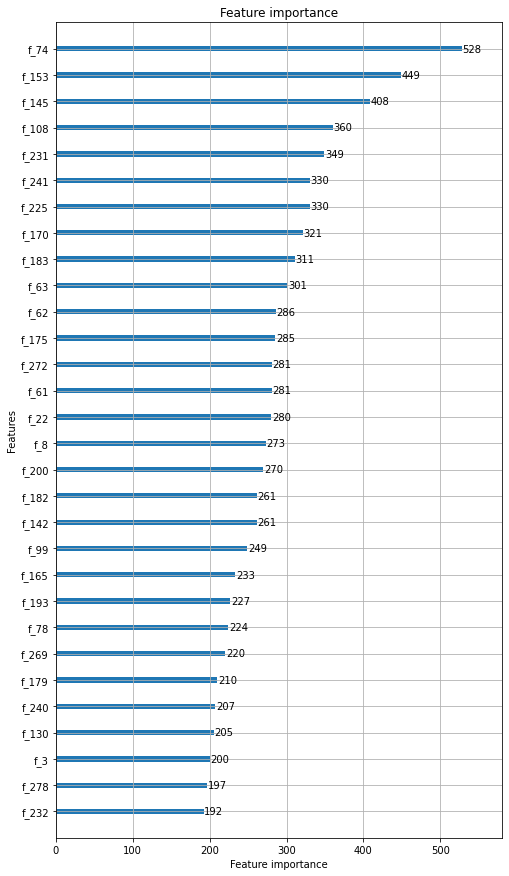

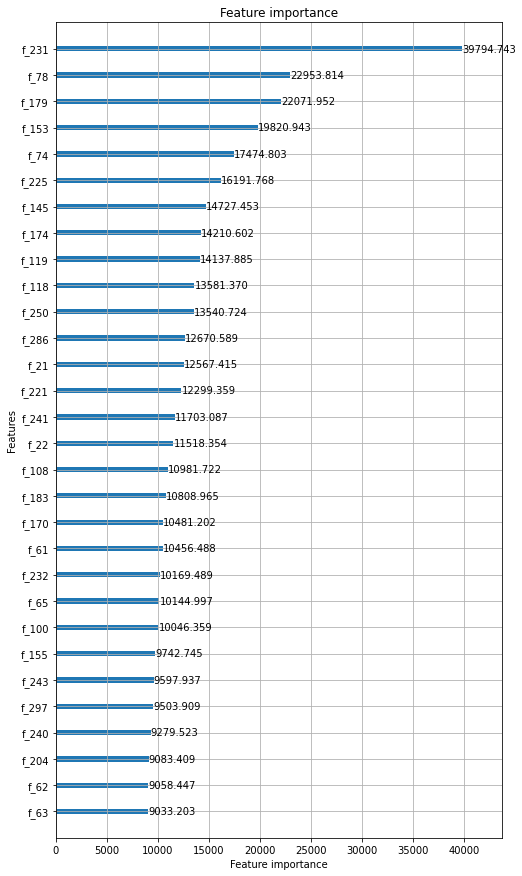

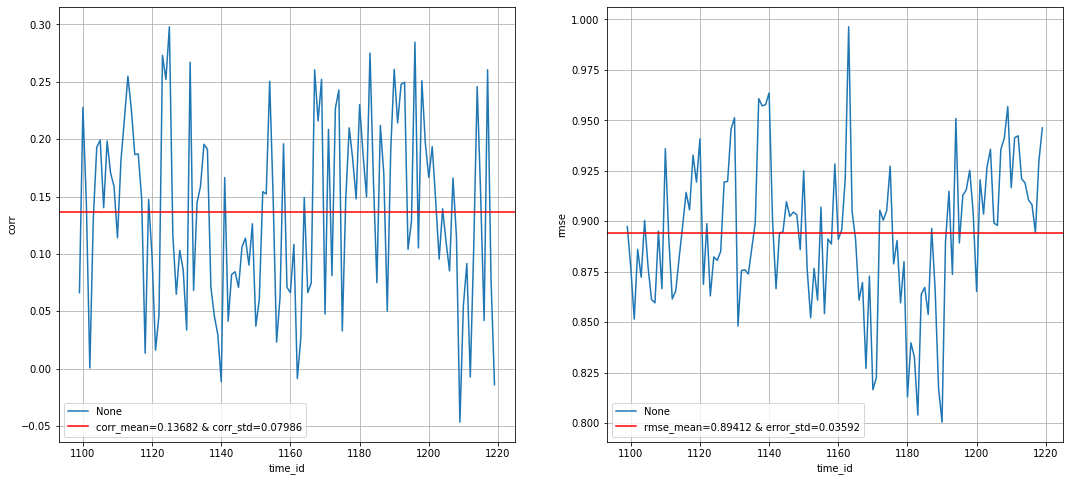

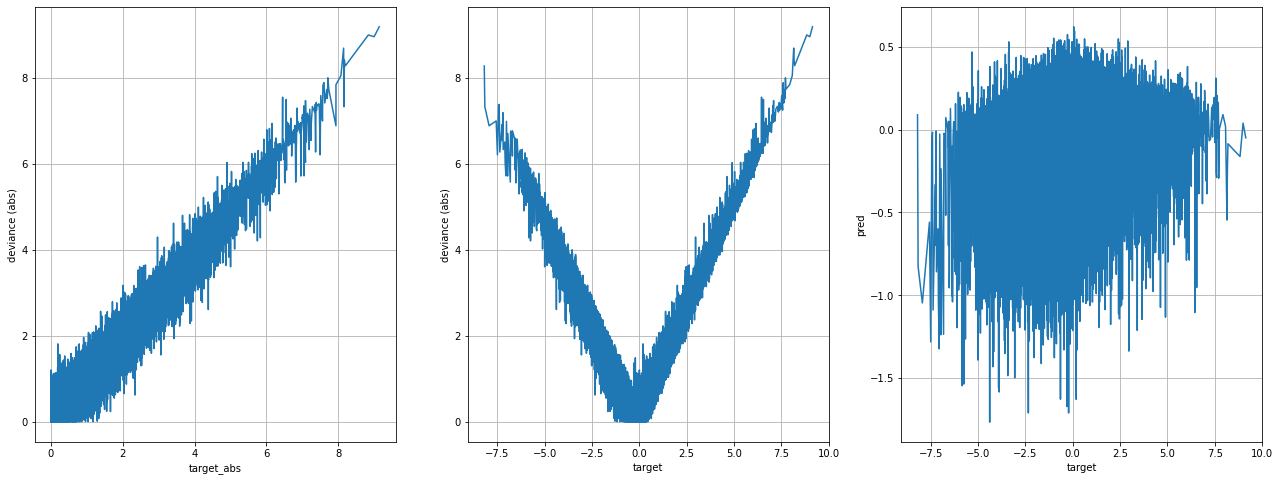

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 0.906976	valid_0's pearsonr: 0.10241
[40]	valid_0's rmse: 0.905517	valid_0's pearsonr: 0.111498
[60]	valid_0's rmse: 0.904732	valid_0's pearsonr: 0.116167
[80]	valid_0's rmse: 0.904155	valid_0's pearsonr: 0.120259
[100]	valid_0's rmse: 0.903669	valid_0's pearsonr: 0.123936
[120]	valid_0's rmse: 0.903268	valid_0's pearsonr: 0.126862
[140]	valid_0's rmse: 0.902959	valid_0's pearsonr: 0.129135
[160]	valid_0's rmse: 0.902694	valid_0's pearsonr: 0.130874
[180]	valid_0's rmse: 0.902486	valid_0's pearsonr: 0.132258
[200]	valid_0's rmse: 0.902287	valid_0's pearsonr: 0.133501
[220]	valid_0's rmse: 0.902131	valid_0's pearsonr: 0.134452
[240]	valid_0's rmse: 0.902044	valid_0's pearsonr: 0.134839
[260]	valid_0's rmse: 0.90193	valid_0's

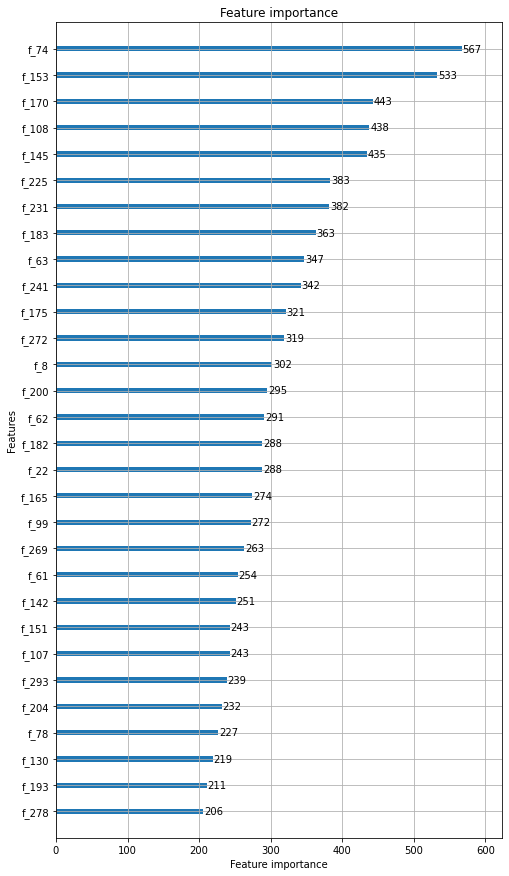

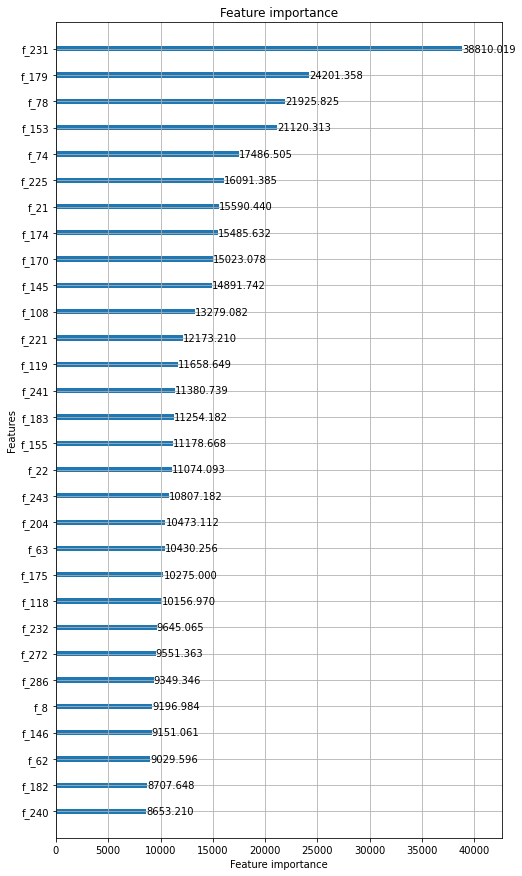

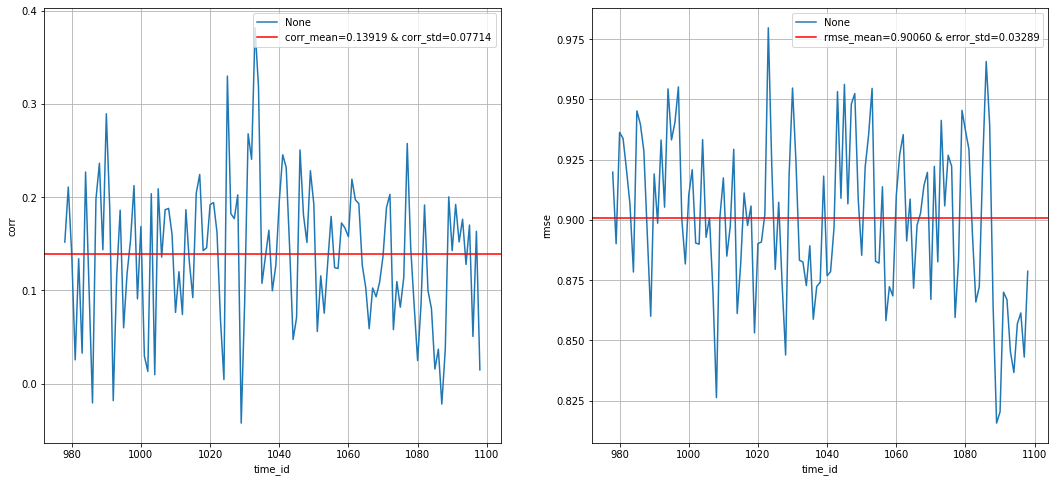

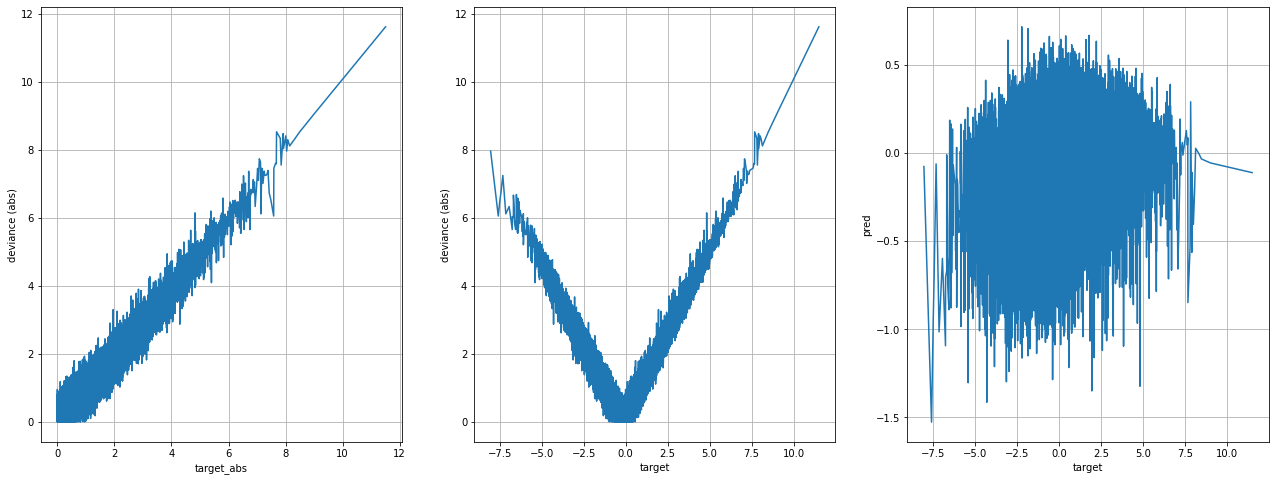

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871
Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 0.940983	valid_0's pearsonr: 0.0882224
[40]	valid_0's rmse: 0.939903	valid_0's pearsonr: 0.0957566
[60]	valid_0's rmse: 0.939246	valid_0's pearsonr: 0.101448
[80]	valid_0's rmse: 0.938745	valid_0's pearsonr: 0.10598
[100]	valid_0's rmse: 0.938244	valid_0's pearsonr: 0.110618
[120]	valid_0's rmse: 0.937901	valid_0's pearsonr: 0.113596
[140]	valid_0's rmse: 0.937507	valid_0's pearsonr: 0.117061
[160]	valid_0's rmse: 0.937242	valid_0's pearsonr: 0.119277
[180]	valid_0's rmse: 0.936993	valid_0's pearsonr: 0.121254
[200]	valid_0's rmse: 0.936789	valid_0's pearsonr: 0.122868
[220]	valid_0's rmse: 0.936597	valid_0's pearsonr: 0.124334
[240]	valid_0's rmse: 0.936444	valid_0's pearsonr: 0.125476
[260]	valid_0's rmse: 0.936358	valid_

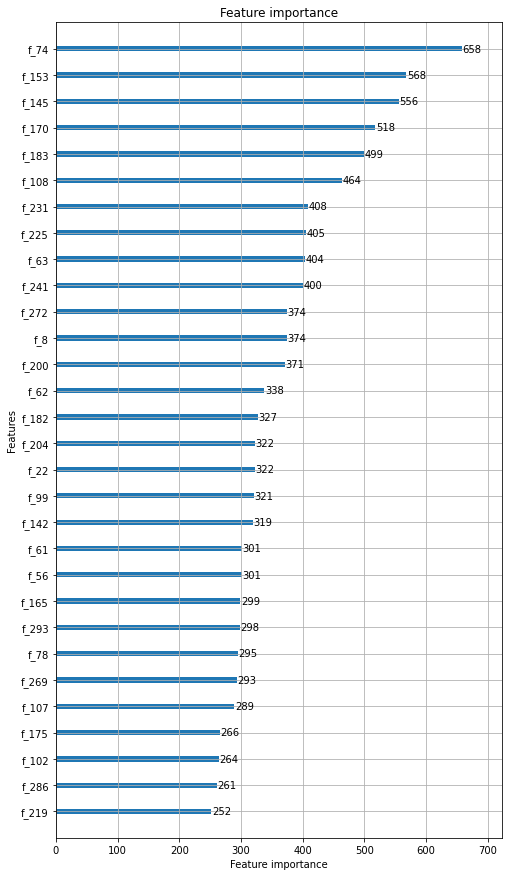

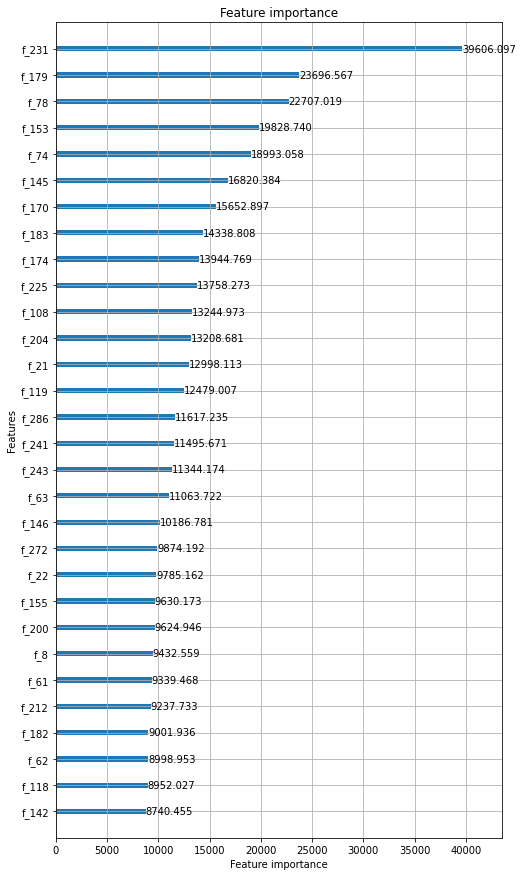

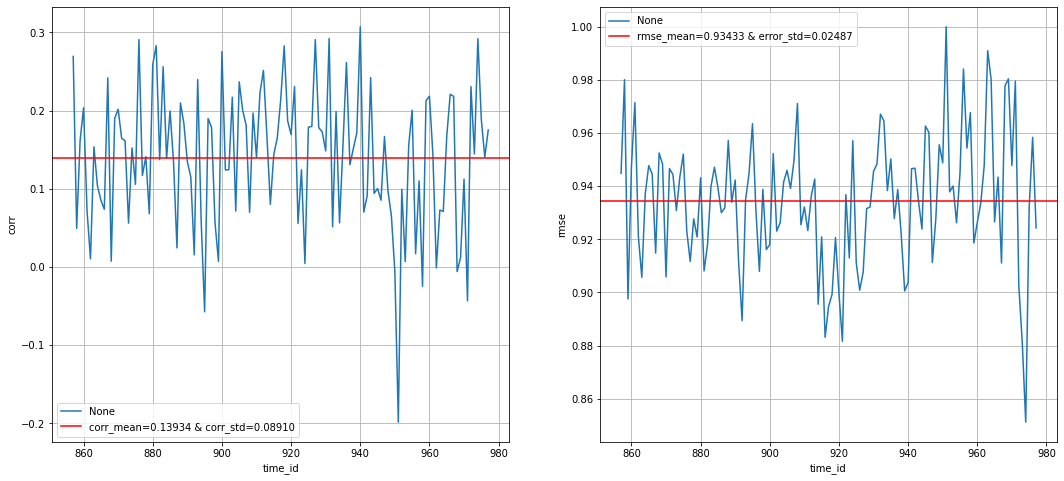

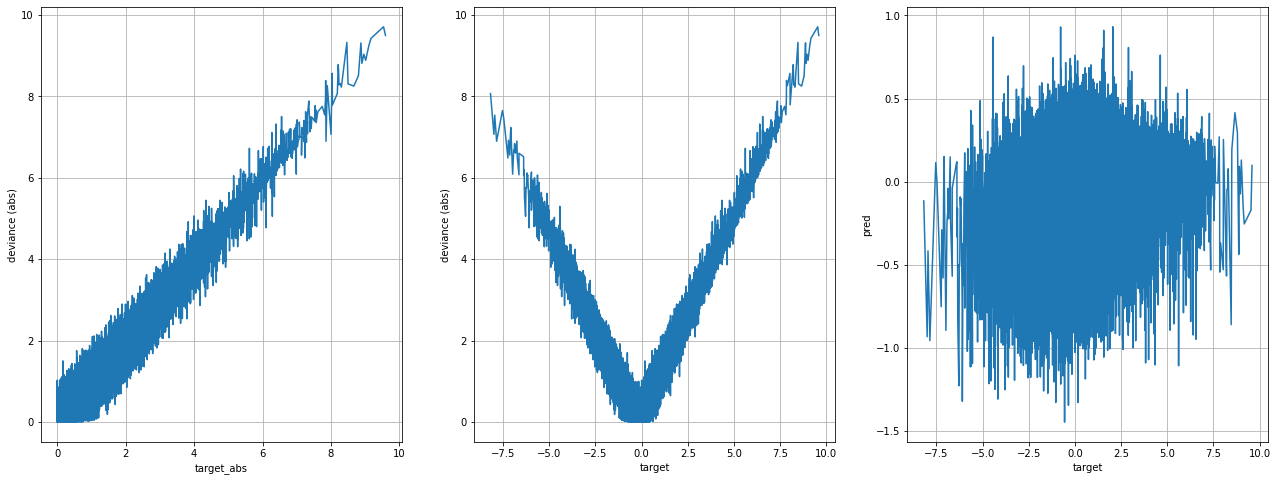

n_iterations: 728


In [9]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            num_boost_round=3000,
            valid_sets=[valid_dset,],
            early_stopping_rounds=50,
            verbose_eval=20,
            feval=pearsonr,
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 550
    

print("n_iterations:", n_iterations)

In [10]:
metrics

{'corr_mean': [0.13681666176258114, 0.13918762399375956, 0.13933841108524997],
 'corr_std': [0.07985816119714886, 0.07714404470184055, 0.08910324971421955],
 'error_mean': [0.8941177237470409, 0.9005959869887066, 0.9343251800454248],
 'error_std': [0.03592163395095577, 0.03289450807639978, 0.024865086816575278]}

In [11]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.13844756561386357

In [12]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9096796302603907

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.91503	training's pearsonr: 0.125455
[40]	training's rmse: 0.912905	training's pearsonr: 0.135576
[60]	training's rmse: 0.911454	training's pearsonr: 0.144637
[80]	training's rmse: 0.910283	training's pearsonr: 0.152726
[100]	training's rmse: 0.909305	training's pearsonr: 0.159596
[120]	training's rmse: 0.908459	training's pearsonr: 0.165397
[140]	training's rmse: 0.907662	training's pearsonr: 0.170912
[160]	training's rmse: 0.906938	training's pearsonr: 0.175748
[180]	training's rmse: 0.906257	training's pearsonr: 0.180241
[200]	training's rmse: 0.905614	training's pearsonr: 0.18429
[220]	training's rmse: 0.904967	training's pearsonr: 0.188544
[240]	training's rmse: 0.904371	training's pearsonr: 0.192314
[260]	training's rmse: 0.903772	training's pearsonr: 0.19608
[280]	training's

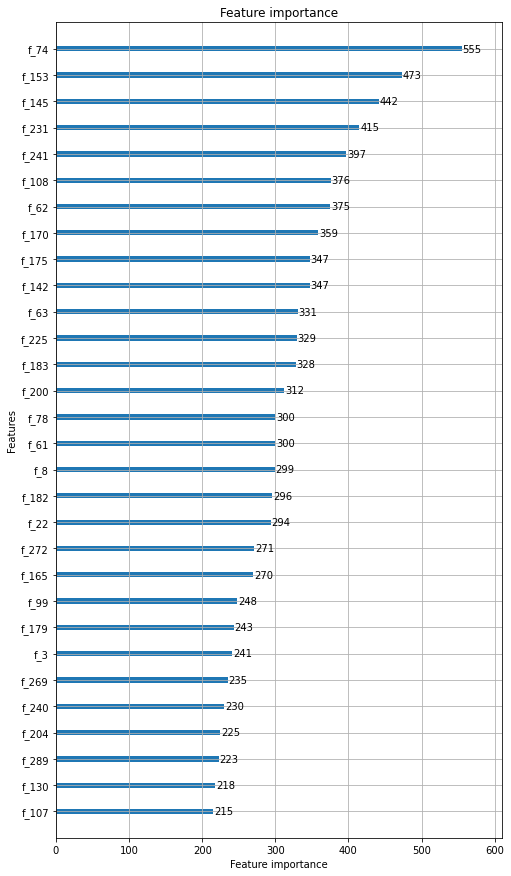

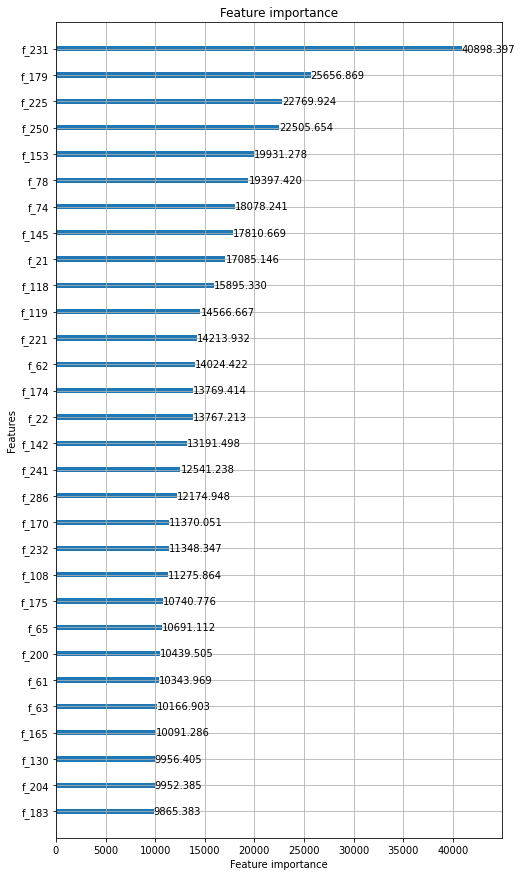

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914976	training's pearsonr: 0.127032
[40]	training's rmse: 0.912744	training's pearsonr: 0.136934
[60]	training's rmse: 0.911343	training's pearsonr: 0.145562
[80]	training's rmse: 0.910269	training's pearsonr: 0.152679
[100]	training's rmse: 0.9093	training's pearsonr: 0.159395
[120]	training's rmse: 0.908444	training's pearsonr: 0.165315
[140]	training's rmse: 0.907667	training's pearsonr: 0.170731
[160]	training's rmse: 0.906912	training's pearsonr: 0.175872
[180]	training's rmse: 0.906236	training's pearsonr: 0.180279
[200]	training's rmse: 0.90557	training's pearsonr: 0.184679
[220]	training's rmse: 0.904921	training's pearsonr: 0.188793
[240]	training's rmse: 0.904318	training's pearsonr: 0.19275
[260]	training's rmse: 0.903751	training's pearsonr: 0.196263
[280]	training's 

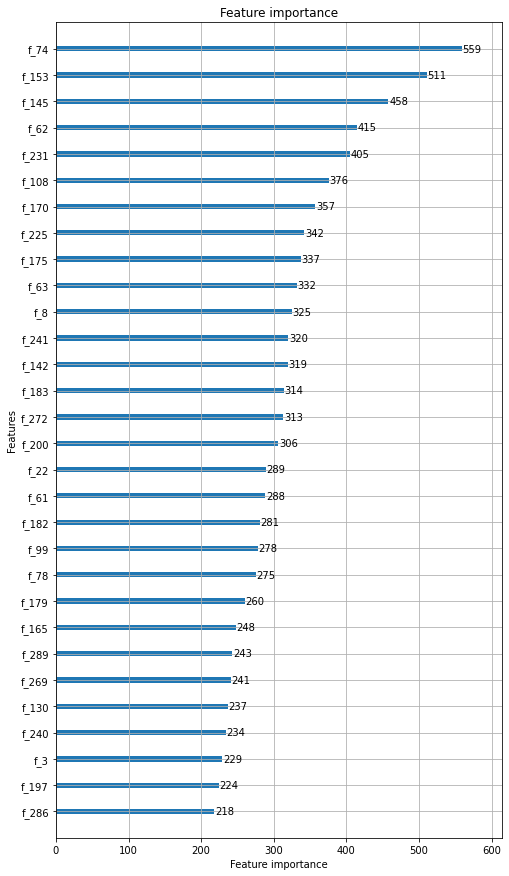

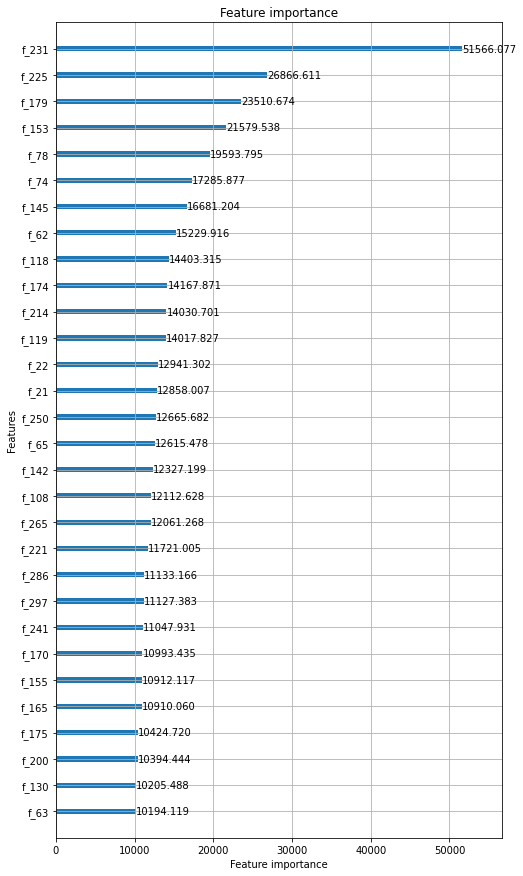

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.9151	training's pearsonr: 0.125211
[40]	training's rmse: 0.912932	training's pearsonr: 0.13523
[60]	training's rmse: 0.911511	training's pearsonr: 0.144144
[80]	training's rmse: 0.910363	training's pearsonr: 0.151911
[100]	training's rmse: 0.9094	training's pearsonr: 0.158632
[120]	training's rmse: 0.908513	training's pearsonr: 0.164882
[140]	training's rmse: 0.907718	training's pearsonr: 0.170398
[160]	training's rmse: 0.906967	training's pearsonr: 0.175417
[180]	training's rmse: 0.906296	training's pearsonr: 0.179813
[200]	training's rmse: 0.905642	training's pearsonr: 0.184071
[220]	training's rmse: 0.905006	training's pearsonr: 0.188133
[240]	training's rmse: 0.904402	training's pearsonr: 0.192075
[260]	training's rmse: 0.903825	training's pearsonr: 0.195769
[280]	training's r

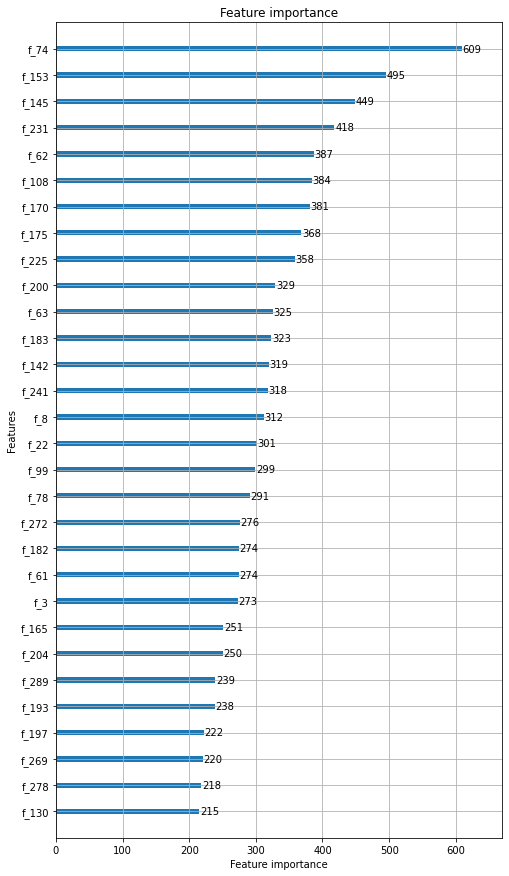

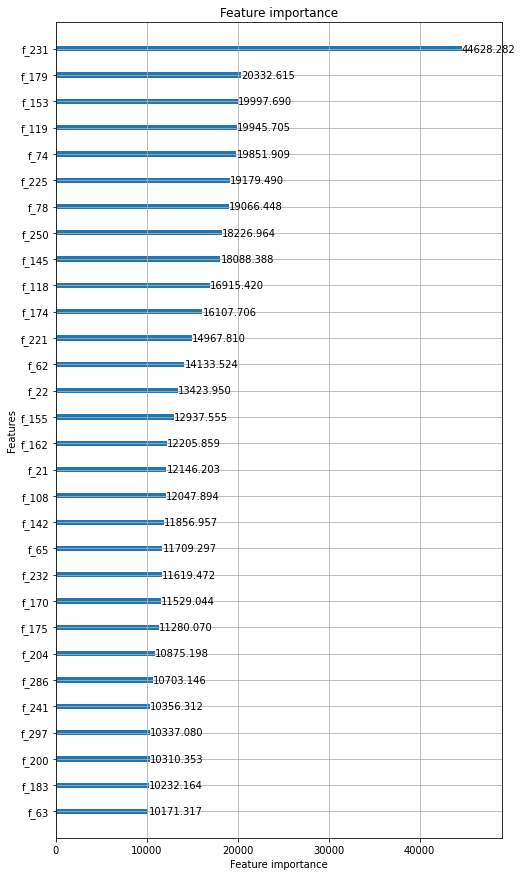

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914969	training's pearsonr: 0.126054
[40]	training's rmse: 0.912802	training's pearsonr: 0.136364
[60]	training's rmse: 0.911393	training's pearsonr: 0.145153
[80]	training's rmse: 0.910278	training's pearsonr: 0.152861
[100]	training's rmse: 0.909341	training's pearsonr: 0.159245
[120]	training's rmse: 0.908519	training's pearsonr: 0.164948
[140]	training's rmse: 0.907729	training's pearsonr: 0.170309
[160]	training's rmse: 0.906952	training's pearsonr: 0.175543
[180]	training's rmse: 0.90625	training's pearsonr: 0.180262
[200]	training's rmse: 0.905598	training's pearsonr: 0.184641
[220]	training's rmse: 0.904957	training's pearsonr: 0.188801
[240]	training's rmse: 0.904357	training's pearsonr: 0.192512
[260]	training's rmse: 0.903768	training's pearsonr: 0.196054
[280]	training

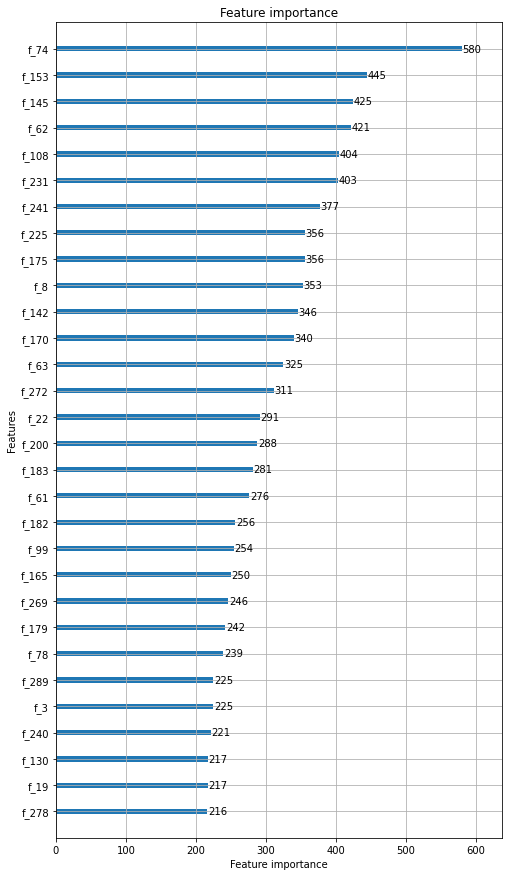

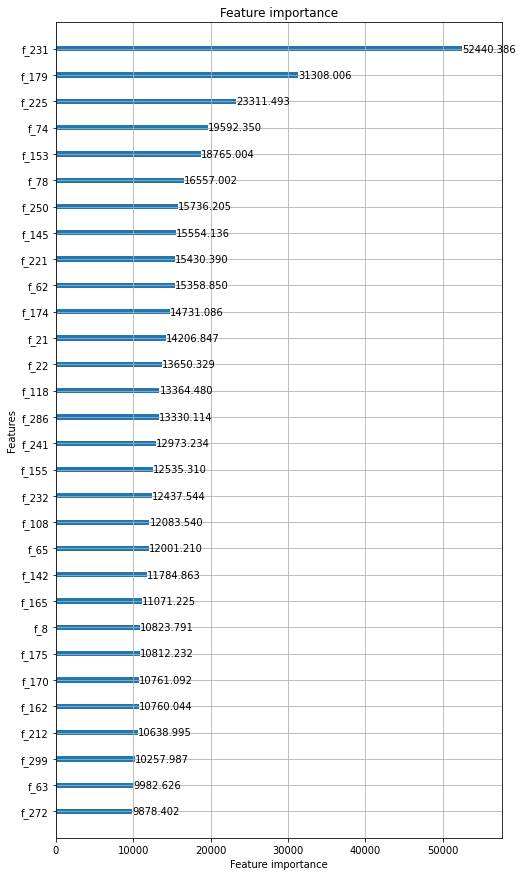

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.915003	training's pearsonr: 0.12602
[40]	training's rmse: 0.912853	training's pearsonr: 0.135746
[60]	training's rmse: 0.911417	training's pearsonr: 0.144624
[80]	training's rmse: 0.910322	training's pearsonr: 0.15213
[100]	training's rmse: 0.909337	training's pearsonr: 0.159152
[120]	training's rmse: 0.908506	training's pearsonr: 0.164785
[140]	training's rmse: 0.907712	training's pearsonr: 0.170254
[160]	training's rmse: 0.906993	training's pearsonr: 0.175073
[180]	training's rmse: 0.906322	training's pearsonr: 0.179629
[200]	training's rmse: 0.905684	training's pearsonr: 0.183729
[220]	training's rmse: 0.905052	training's pearsonr: 0.187871
[240]	training's rmse: 0.904449	training's pearsonr: 0.191475
[260]	training's rmse: 0.903863	training's pearsonr: 0.195103
[280]	training'

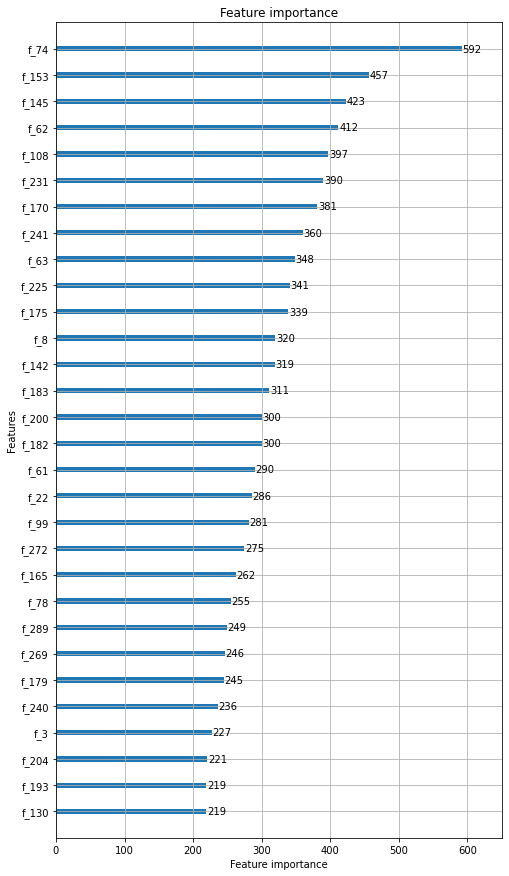

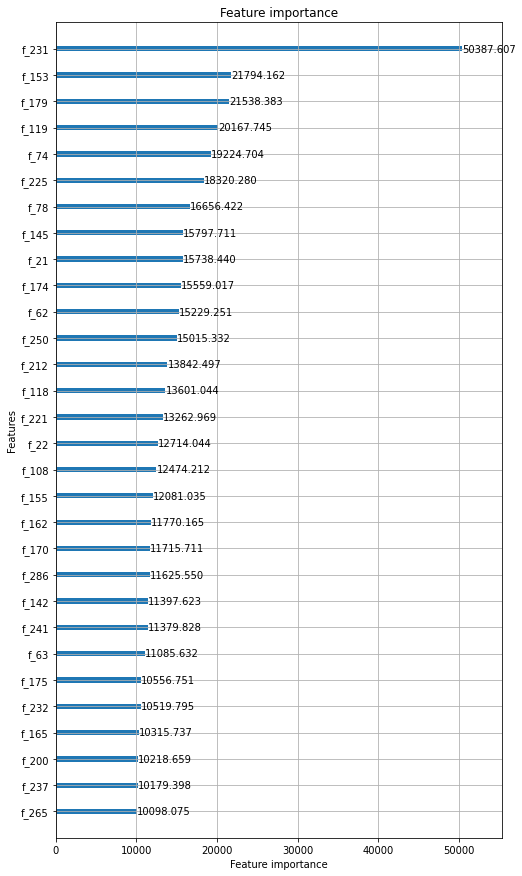

In [13]:
seeds = [2,7,11,19,23]
models = list()

for seed in seeds:
    model_params["seed"] = seed
    model_params["extra_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=n_iterations,
        valid_sets=[train_dset,],
        verbose_eval=20,
        feval=pearsonr,
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [14]:
for seed,model in zip(seeds,models): 
    model.save_model(f"lgbm-seed{seed}.txt")

***
## inference

In [15]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

In [16]:
features = [f"f_{i}" for i in range(300)]

for (test_df, sample_prediction_df) in iter_test:  
    preds = [model.predict(test_df[features]) for model in models]
    sample_prediction_df['target'] = np.mean(preds, axis=0)
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,row_id,target
0,1220_1,-0.141926
1,1220_2,-0.070370


,row_id,target
0,1221_0,-0.066200
1,1221_1,-0.147446
2,1221_2,-0.145538


,row_id,target
0,1222_0,-0.072411
1,1222_1,-0.109380
2,1222_2,-0.104480


,row_id,target
0,1223_0,-0.061061


***